# `pygraph` 简介

在 JAX 中，各种强大的函数转换适用于 pytree 数据结构（如字典、列表、元组等树状结构）。基于 pytree，JAX 能够高效地执行自动微分、向量化和并行化操作。然而，许多实际应用场景，尤其是复杂的物理结构和神经网络模型，更适合用图（graph）而非简单的树结构来表示。因此，`brainstate` 库引入了 `pygraph` 表示，以为图数据结构提供强大的 JAX 函数转换支持。

## 什么是 `pygraph`？

`pygraph` 是 `brainstate` 中专门设计用于支持 JAX 函数转换的数据结构。与常见的树结构相比，图结构能够表达更加多样的节点关系和依赖性，适用于更复杂的模型结构。特别是在模型状态需要依赖多个节点的交互作用时，图结构在表达上显得更为灵活。

`pygraph` 模块以 `brainstate.graph.Node` 作为图的基本节点，通过定义节点之间的关系（边）来构建图形结构。每个节点可以包含任意的 pytree 数组数据或 `pygraph` 子结构，使得图的构建更加灵活和模块化。

我们可以将 `brainstate.graph.Node` 视为一个类容器，其中的属性代表其叶子节点。容器之间可以相互引用，从而形成复杂的图结构。

In [1]:
import jax
import jax.numpy as jnp

import brainstate 

In [2]:
class A(brainstate.graph.Node):
    def __init__(self):
        self.w = brainstate.random.rand(2, 3)
        self.b = brainstate.ShortTermState(brainstate.random.rand(3))

在上面的代码中，我们定义了一个类 `A`，该类继承自 `brainstate.graph.Node`。在类的初始化函数中，我们定义了两个属性 `w` 和 `b`，分别表示一个随机生成的 2x3 矩阵和一个随机生成的长度为 3 的数组。这两个数据结构都是 JAX 的 pytree 结构。

值得注意的是，`brainstate.graph.Node` 允许我们创建循环引用。例如，

In [3]:
a = A()
a.self = a

我们将 `a` 的 `self` 属性设置为 `a`，这样就形成了一个循环引用。这种引用方式在树结构中是不被允许的，但在图结构中则是合法的。这种循环引用可以用于表示复杂的模型结构，例如循环神经网络中的循环连接。通过这种灵活的引用方式，我们能够更自然地表达神经网络中节点之间的动态关系。

In [4]:
# 查看图结构

brainstate.graph.graphdef(a)

NodeDef(
  type=A,
  index=0,
  attributes=('b', 'self', 'w'),
  subgraphs={
    'self': NodeRef(
      type=A,
      index=0
    )
  },
  static_fields={
    'w': Array([[0.44416273, 0.10539985, 0.5645528 ],
           [0.24569166, 0.18704593, 0.5005108 ]], dtype=float32)
  },
  leaves={
    'b': NodeRef(
      type=ShortTermState,
      index=1
    )
  },
  metadata=(<class '__main__.A'>,),
  index_mapping=None
)

## `brainstate.graph.Node` 概述

`brainstate.graph.Node` 是 `pygraph` 中的核心类，定义了每个节点的结构和行为。每个节点的 **属性** 是其叶子节点，可以是任意 JAX 数组或其他可转换的数据类型。每个节点的 **方法** 则提供了对该节点所包含数据的操作、更新和变换功能。

在 `brainstate` 中，任意神经网络模块都可以作为 `brainstate.graph.Node` 的子类。
通过这种设计，我们能够灵活地构建各种神经网络组件，使其既具备良好的可扩展性，又能充分利用 JAX 提供的强大计算能力。例如，我们可以定义一个简单的线性层模块： 


In [5]:
class MLP(brainstate.graph.Node):
    def __init__(self):
        self.l1 = brainstate.nn.Linear(2, 3)
        self.l2 = brainstate.nn.Linear(3, 4)
        self.l3 = brainstate.nn.Linear(4, 5)
        self.st = brainstate.ShortTermState(brainstate.random.rand(5))

可以通过以下属性和方法创建和操作节点：

- **数据存储**：每个 `brainstate.graph.Node` 节点的 *属性* 可以存储任意 JAX 数组或其他可转换的数据类型。
- **节点连接**：每个 `brainstate.graph.Node` 节点的 *属性* 可以连接到其他 `brainstate.graph.Node` 节点，从而建立复杂的依赖图，例如在上面的 `MLP` 类中的三个线性层模块。
- **属性及其路径**：每个 `brainstate.graph.Node` 节点在检索和转换时都包含其独特的路径，这有助于在复杂结构中进行识别和检索。该路径表示节点在图中各层次嵌套结构中的位置。

例如，我们可以通过以下代码查看 `MLP` 图中的叶子数据点：

In [6]:
mlp = MLP()

for path, leaf in brainstate.graph.iter_leaf(mlp):
    print(path, leaf.__class__.__name__ if isinstance(leaf, brainstate.State) else leaf)

('l1', '_in_size', 0) 2
('l1', '_out_size', 0) 3
('l1', 'weight') ParamState
('l2', '_in_size', 0) 3
('l2', '_out_size', 0) 4
('l2', 'weight') ParamState
('l3', '_in_size', 0) 4
('l3', '_out_size', 0) 5
('l3', 'weight') ParamState
('st',) ShortTermState


我们也可以通过如下代码查看 ``MLP`` 图中的所有节点：

In [7]:
for path, node in brainstate.graph.iter_node(mlp):
    print(path, node.__class__.__name__)

('l1',) Linear
('l2',) Linear
('l3',) Linear
() MLP


## `pygraph` 常用函数

`brainstate` 提供了许多用于操作 `pygraph` 的实用工具，这些工具可以在 [`brainstate.graph` 模块](../apis/graph.rst) 中找到。

总体来说，`pygraph` 常用的函数主要分为以下几类：

- **图结构操作**：用于构建和检索图结构的函数，包括：
    - `brainstate.graph.graphdef`：查看图结构
    - `brainstate.graph.iter_node`：遍历图结构中的所有子节点
    - `brainstate.graph.iter_leaf`：遍历图结构中的所有数据
    - `brainstate.graph.nodes`：查看图结构中的所有节点
    - `brainstate.graph.states`：查看图结构中的所有 `State` 实例

- **图结构变换**：用于对图结构进行变换和操作的函数，包括：
    - `brainstate.graph.treefy_states`：将图结构中的所有 `State` 实例转换为 pytree
    - `brainstate.graph.clone`：复制图结构
    - `brainstate.graph.treefy_split`：将图结构拆分为图结构 `graphdef` 和 pytree 化的 `State`
    - `brainstate.graph.treefy_merge`：将图结构 `graphdef` 和 pytree 化的 `State` 合并为图结构
    - `brainstate.graph.flatten`：将图结构展平为`graphdef` 和 `State` 集合
    - `brainstate.graph.unflatten`：将展平的图结构还原为原始图结构

- **图结构修改**：用于对图结构进行修改和更新的函数，包括：
    - `brainstate.graph.pop_states`：删除图结构中满足某种条件的 `State` 实例（见下文的``filter`` 协议部分）
    - `brainstate.graph.update_states`：更新图结构中满足某种条件的 `State` 实例

- **图结构转换**：用于在 pygraph 和 pytree 数据结构之间相互转换的函数，包括：
    - `brainstate.graph.graph_to_tree`：将图结构转换为 pytree
    - `brainstate.graph.tree_to_graph`：将 pytree 转换为图结构

这些函数为开发者提供了丰富的工具，以便在构建和操作图结构时实现灵活性和高效性。

在介绍了``pygraph``的基本概念和常用函数之后，我们将通过一个简单的例子来展示如何使用``pygraph``模块构建和操作图结构。

In [8]:
# 分割图结构为 graphdef 和 树化的states

graphdef, tree_states = brainstate.graph.treefy_split(mlp)

In [9]:
graphdef

NodeDef(
  type=MLP,
  index=0,
  attributes=('l1', 'l2', 'l3', 'st'),
  subgraphs={
    'l1': NodeDef(
      type=Linear,
      index=1,
      attributes=('_in_size', '_name', '_out_size', 'w_mask', 'weight'),
      subgraphs={
        '_in_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 2
          },
          leaves={},
          metadata=PyTreeDef((*,)),
          index_mapping=None
        ),
        '_name': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_out_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 3
          },
          leaves={},
          metadata=PyTreeDef((*,)),
   

In [10]:
tree_states

NestedDict({
  'l1': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[ 0.5187215 ,  0.42294285, -0.19334847],
             [ 0.07706995, -0.35018158,  0.9515583 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l2': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.7998994 , -1.1028353 , -1.3137802 , -0.6670054 ],
             [ 0.67895615, -1.1388712 , -0.3994556 ,  0.43608958],
             [ 0.9811476 ,  0.07966074,  0.49631312, -0.01195422]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l3': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.01027286,  0.72686285, -0.13186036,  0.8553584 ,  0.0084674 ],
             [ 0.508997  ,  0.46148732, -0.9233172 ,  0.31171682,  0.6931351 ],
             [-0.03430631, -0.35440183, -0.28967488, -0.12506197,  0.80800104],
             [-0.77022

In [11]:
# 合并图结构和树化的states

mlp2 = brainstate.graph.treefy_merge(graphdef, tree_states)

mlp2

MLP(
  l1=Linear(
    in_size=(2,),
    out_size=(3,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[ 0.5187215 ,  0.42294285, -0.19334847],
             [ 0.07706995, -0.35018158,  0.9515583 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
    )
  ),
  l2=Linear(
    in_size=(3,),
    out_size=(4,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.7998994 , -1.1028353 , -1.3137802 , -0.6670054 ],
             [ 0.67895615, -1.1388712 , -0.3994556 ,  0.43608958],
             [ 0.9811476 ,  0.07966074,  0.49631312, -0.01195422]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
    )
  ),
  l3=Linear(
    in_size=(4,),
    out_size=(5,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.01027286,  0.72686285, -0.13186036,  0.8553584 ,  0.0084674 ],
             [ 0.508997  ,  0.46148732, -0.9233172 ,  0.31171682,  0.6931351 ],
             [-0.03430631, -0.35440183, -0.28967488,

In [12]:
# 查看图结构中的所有states

states = brainstate.graph.states(mlp2)

states

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[ 0.5187215 ,  0.42294285, -0.19334847],
           [ 0.07706995, -0.35018158,  0.9515583 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[-0.7998994 , -1.1028353 , -1.3137802 , -0.6670054 ],
           [ 0.67895615, -1.1388712 , -0.3994556 ,  0.43608958],
           [ 0.9811476 ,  0.07966074,  0.49631312, -0.01195422]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[-0.01027286,  0.72686285, -0.13186036,  0.8553584 ,  0.0084674 ],
           [ 0.508997  ,  0.46148732, -0.9233172 ,  0.31171682,  0.6931351 ],
           [-0.03430631, -0.35440183, -0.28967488, -0.12506197,  0.80800104],
           [-0.7702278 ,  1.1087404 , -0.11850059, -1.1407769 ,  0.6917508 ]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  ),
  ('st',

值得注意的是，对于大部分检索``State``实例的图操作函数，都支持传入一系列``filter``函数，用于筛选出满足某种条件的``State``实例。比如，如果只需要筛选出所有的``ShortTermState``实例，可以通过以下代码实现：

In [13]:
short_term_states = brainstate.graph.states(mlp2, brainstate.ShortTermState)

short_term_states

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.24389029, 0.05778766, 0.88370955, 0.46163833, 0.9883605 ],      dtype=float32)
  )
})

## ``filter`` 过滤器语法


一般来说，``filter``具有如下函数形式：

```python
def predicate(path: tuple[Key, ...], value: Any) -> bool:
    ...
```

其中 `Key` 是可哈希和可比较的数据类型（往往是字符串），`path` 是表示`value`所对应的路径嵌套结构的 `Key` 元组，`value` 是路径上的值。如果值应包含在该``filter``中，函数返回 `True`，否则返回 `False`。

比如，我们可以定义一个 ``filter`` 函数，用于筛选出所有的 ``ParamState`` 实例：

In [14]:
def is_param(path, value) -> bool:
    return isinstance(value, brainstate.ParamState)


print(f'{is_param((), brainstate.ParamState(0.)) = }')

is_param((), bst.ParamState(0.)) = True


但是，为了简化 ``filter`` 函数的创建， ``brainstate`` 提供了一个小型的领域特定语言（domain-specific language，DSL）。该类型允许用户传递类型、布尔值、省略号、元组/列表等，并在内部将它们转换为相应的谓词、元组/列表等。

| 字面量 | 可调用对象 | 描述 |
|--------|----------------------|-------------|
| `...` 或 `True` | `Everything()` | 匹配所有值 |
| `None` 或 `False` | `Nothing()` | 不匹配任何值 |
| `type` | `OfType(type)` | 匹配类型为 `type` 的实例,或具有类型为 `type` 的 `type` 属性的值 |
| | `PathContains(key)` | 匹配关联的 `path` 中包含指定 `key` 的值 |
| `'{filter}'` <span style="color:gray">str</span> | `WithTag('{filter}')` | 匹配具有等于 `'{filter}'` 的字符串 `tag` 属性的值。被 `RngKey` 和 `RngCount` 使用。|
| `(*filters)` <span style="color:gray">tuple</span> 或 `[*filters]` <span style="color:gray">list</span> | `Any(*filters)` | 匹配满足任一内部 `filters` 的值 |
| | `All(*filters)` | 匹配满足所有内部 `filters` 的值 |
| | `Not(filter)` | 匹配不满足内部 `filter` 的值 |

比如，我们可以使用 ``filter`` DSL 来定义一个筛选出所有的 ``ParamState`` 实例和剩下的其他实例的 ``State``：

In [15]:
params, others = brainstate.graph.states(mlp, brainstate.ParamState, ...)

params

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[ 0.5187215 ,  0.42294285, -0.19334847],
           [ 0.07706995, -0.35018158,  0.9515583 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[-0.7998994 , -1.1028353 , -1.3137802 , -0.6670054 ],
           [ 0.67895615, -1.1388712 , -0.3994556 ,  0.43608958],
           [ 0.9811476 ,  0.07966074,  0.49631312, -0.01195422]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[-0.01027286,  0.72686285, -0.13186036,  0.8553584 ,  0.0084674 ],
           [ 0.508997  ,  0.46148732, -0.9233172 ,  0.31171682,  0.6931351 ],
           [-0.03430631, -0.35440183, -0.28967488, -0.12506197,  0.80800104],
           [-0.7702278 ,  1.1087404 , -0.11850059, -1.1407769 ,  0.6917508 ]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  )
})

In [16]:
others

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.24389029, 0.05778766, 0.88370955, 0.46163833, 0.9883605 ],      dtype=float32)
  )
})

## `pygraph` 与 `pytree` 的转换

`brainstate` 提供了一系列用于 `pygraph` 和 `pytree` 之间相互转换的函数，这些函数可以在 [`brainstate.graph` 模块](../apis/graph.rst) 中找到。特别地，我们在这里介绍两个常用的函数：

- **`brainstate.graph.treefy_split`**：将图结构拆分为图结构和树化的 `TreefyState` 实例。该函数可以用于将图结构中的所有 `State` 实例转换为 pytree，同时保留图结构中的其他节点信息。

- **`brainstate.graph.treefy_merge`**：将图结构和树化的 `TreefyState` 实例重新合并为图结构。该函数可以用于将 pytree 转换回图结构，并保留 pytree 中的其他节点信息。

这两个函数可以帮助用户在图结构和 pytree 之间进行灵活的转换，从而更方便地利用 JAX 的函数转换功能，特别是在复杂的模型结构中。

我们可以通过以下代码来演示这两个函数的使用：

In [17]:
class Linear(brainstate.nn.Module):
    def __init__(self, din: int, dout: int):
        super().__init__()
        self.w = brainstate.ParamState(brainstate.random.rand(din, dout))
        self.b = brainstate.ParamState(jnp.zeros((dout,)))

    def __call__(self, x):
        return x @ self.w.value + self.b.value


class Count(brainstate.State):
    pass


class MLP(brainstate.graph.Node):
    def __init__(self, din, dhidden, dout):
        self.count = Count(jnp.array(0))
        self.linear1 = Linear(din, dhidden)
        self.linear2 = Linear(dhidden, dout)

    def __call__(self, x):
        self.count.value += 1
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x

在上面的代码中，我们定义了一个简单的多层感知机模型 ``MLP``，其中包含两个线性层模块 ``Linear`` 和一个计数器 ``Count``。我们可以通过以下代码来查看这个模型的图结构：

In [18]:
model = MLP(1, 32, 1)

graphdef, params_, counts_ = brainstate.graph.treefy_split(MLP(din=1, dhidden=32, dout=1), brainstate.ParamState, Count)

params_

NestedDict({
  'linear1': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
      tag=None
    ),
    'w': TreefyState(
      type=ParamState,
      value=Array([[0.9392605 , 0.7790779 , 0.66677403, 0.08050084, 0.686725  ,
              0.02764857, 0.99246347, 0.9000404 , 0.7771156 , 0.62787473,
              0.1648587 , 0.4361236 , 0.71830595, 0.706252  , 0.69551015,
              0.72018254, 0.32448876, 0.5692558 , 0.9435898 , 0.12574542,
              0.8008071 , 0.5247209 , 0.05799401, 0.68780065, 0.09367621,
              0.09441042, 0.60562134, 0.66806376, 0.7862117 , 0.2773832 ,
              0.79793155, 0.5861008 ]], dtype=float32),
      tag=None
    )
  },
  'linear2': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0.], dtype=float32),
      tag=None
    ),
    'w': TreefyState(
  

In [19]:
counts_

NestedDict({
  'count': TreefyState(
    type=Count,
    value=Array(0, dtype=int32, weak_type=True),
    tag=None
  )
})

## ``pygraph`` 与 JAX 函数转换

将``pygraph``转换为``pytree``后，我们可以使用JAX的函数转换功能对其进行操作。比如，我们可以使用JAX的``jit``函数对``MLP``模型进行编译，使用``grad``函数对其进行自动微分，使用``vmap``函数对其进行批量操作等。这些函数可以帮助用户更方便地对复杂的模型结构进行高效的计算操作。

我们首先定义一个简单的数据集：

In [20]:
X = jnp.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + brainstate.random.normal(0, 0.1, size=X.shape)


def dataset(batch_size):
    while True:
        idx = brainstate.random.choice(len(X), size=batch_size)
        yield X[idx], Y[idx]

接下来，我们使用``jax.jit``函数对``MLP``模型进行编译，并使用``jax.grad``函数对其进行自动微分：

In [21]:
@jax.jit
def train_step(params, counts, batch):
    x, y = batch

    def loss_fn(params):
        model = brainstate.graph.treefy_merge(graphdef, params, counts)
        y_pred = model(x)
        new_counts = brainstate.graph.treefy_states(model, Count)
        loss = jnp.mean((y - y_pred) ** 2)
        return loss, new_counts

    grad, counts = jax.grad(loss_fn, has_aux=True)(params)
    #                          |-------- sgd ---------|
    params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)

    return params, counts

我们再定义一个测试函数，用于计算模型的损失：

In [22]:
@jax.jit
def test_step(params, counts, batch):
    x, y = batch
    model = brainstate.graph.treefy_merge(graphdef, params, counts)
    y_pred = model(x)
    loss = jnp.mean((y - y_pred) ** 2)
    return {'loss': loss}

接下来，让我们开始训练模型：

In [23]:
total_steps = 10_000
for step, batch in enumerate(dataset(32)):
    params_, counts_ = train_step(params_, counts_, batch)

    if step % 1000 == 0:
        logs = test_step(params_, counts_, (X, Y))
        print(f"step: {step}, loss: {logs['loss']}")

    if step >= total_steps - 1:
        break

step: 0, loss: 3.798895835876465
step: 1000, loss: 0.008471012115478516
step: 2000, loss: 0.008467071689665318
step: 3000, loss: 0.00840870849788189
step: 4000, loss: 0.008454578928649426
step: 5000, loss: 0.008516873233020306
step: 6000, loss: 0.008453031070530415
step: 7000, loss: 0.00842580571770668
step: 8000, loss: 0.00850499514490366
step: 9000, loss: 0.008403446525335312


最后，我们还原出模型，并查看模型的调用次数：

In [24]:
model = brainstate.graph.treefy_merge(graphdef, params_, counts_)
print('times called:', model.count.value)

times called: 10000


最后，我们可以使用训练好的模型对数据进行预测，并查看预测结果：

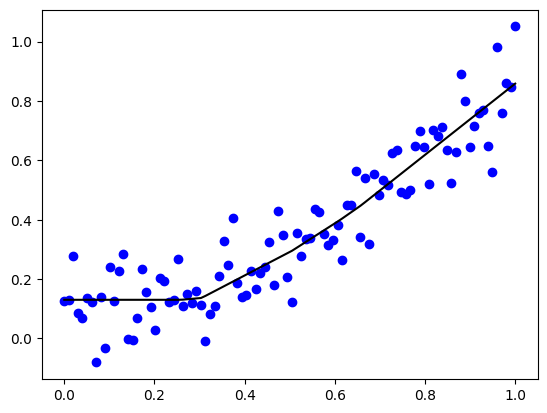

In [25]:
y_pred = model(X)

import matplotlib.pyplot as plt

plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='black')
plt.show()

## 总结

``PyGraph`` 是 ``brainstate`` 库中专门设计的数据结构，旨在为复杂的图结构提供 JAX 函数转换支持。它的核心价值在于:

1. **图结构的灵活表达**
   - 相比传统的树结构(pytree)，图结构能够表达更复杂的节点关系和依赖性
   - 支持循环引用，适合表达循环神经网络等复杂模型结构
   - 节点可以包含任意 pytree 数组数据或子图结构

2. **与 JAX 生态的无缝集成**
   - 支持 JAX 的自动微分、向量化、并行化等核心功能
   - 提供了图结构与 pytree 之间的转换机制
   - 原生支持诸如 vmap、grad 等 JAX 函数转换

我们希望 `PyGraph` 通过其灵活的结构设计和强大的功能支持，能很好地解决了复杂模型构建中的技术挑战。